In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import MDS
from scipy.ndimage import gaussian_filter1d

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [2]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [4]:
def geo_rdm(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        R = squareform(pdist(Xrdv, metric=metric))   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:57<00:00,  4.43s/it]


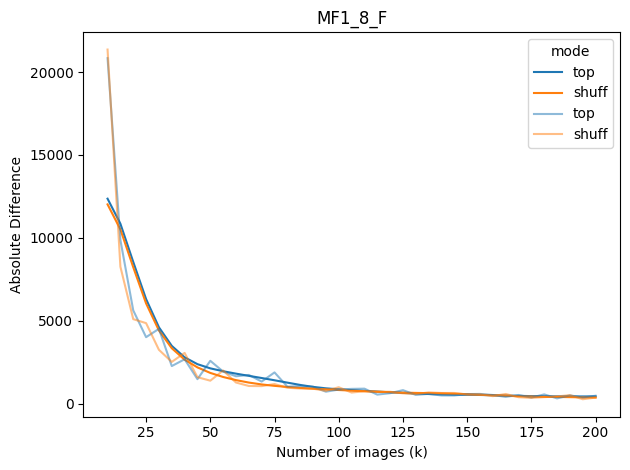

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:44<00:00,  1.12s/it]


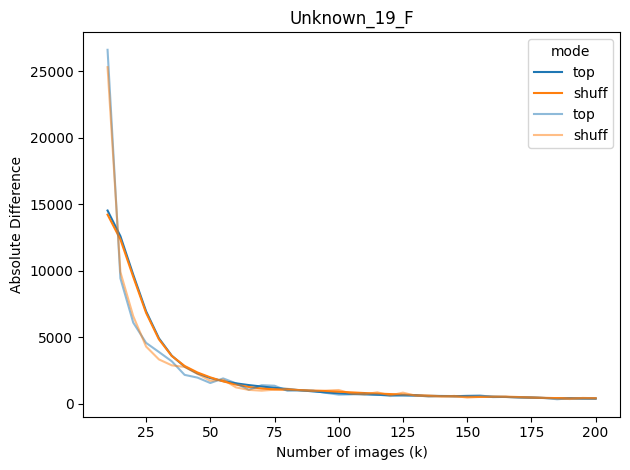

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:48<00:00,  1.21s/it]


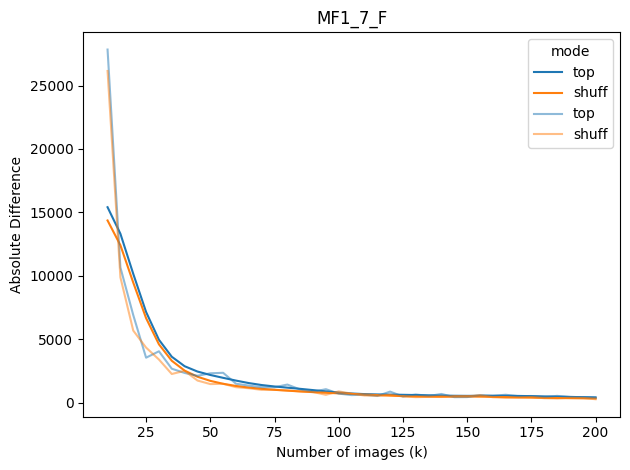

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:46<00:00,  1.17s/it]


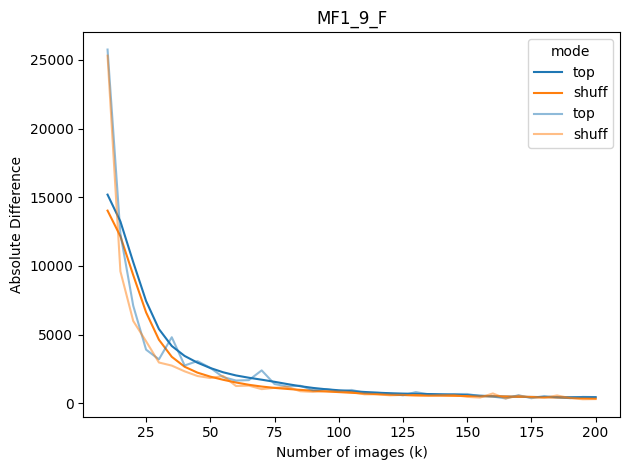

In [66]:
for _roi in ['MF1_8_F', 'Unknown_19_F', 'MF1_7_F', 'MF1_9_F']:
    step = 5

    sizes_top,   top_rdms   = geo_rdm(dat, roi=_roi, mode='top',   step=step)
    sizes_shuff, shuff_rdms = geo_rdm(dat, roi=_roi, mode='shuff', step=step)
    
    def rdm_diffs(rdm_seq, start=2):
        R0 = rdm_seq[start]
        triu = np.triu_indices_from(R0, k=1)
        diffs = [
            # 1 - spearmanr(rdm_seq[i][triu], rdm_seq[i-1][triu])[0]
            np.sum(np.abs(rdm_seq[i][triu] - rdm_seq[i-1][triu]))
            for i in range(start, len(rdm_seq))
        ]
        ks = [sizes_top[i] for i in range(start, len(rdm_seq))]
        return ks, diffs
    
    k_top,   diffs_top   = rdm_diffs(top_rdms, start=1)
    k_shuff, diffs_shuff = rdm_diffs(shuff_rdms, start=1)
    
    df = pd.DataFrame({
        "k":     k_top + k_shuff,
        "diff":  diffs_top + diffs_shuff,
        "mode":  ["top"]*len(diffs_top) + ["shuff"]*len(diffs_shuff),
    })
    
    df["diff_smooth"] = df["diff"].groupby(df["mode"]).transform(
        lambda v: gaussian_filter1d(v, sigma=2)
    )
    
    sns.lineplot(data=df, x="k", y="diff_smooth", hue="mode")
    sns.lineplot(data=df, x="k", y="diff", hue="mode", alpha=0.5)
    
    plt.xlabel("Number of images (k)")
    plt.ylabel("Absolute Difference")
    plt.title(f'{_roi}')
    plt.tight_layout()
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:44<00:00,  1.10s/it]


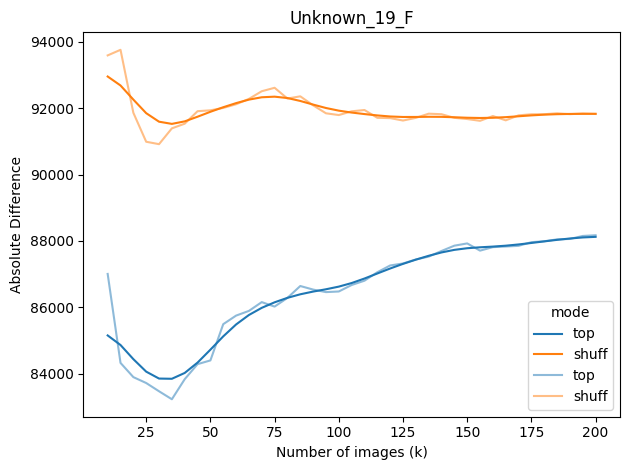

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:48<00:00,  1.22s/it]


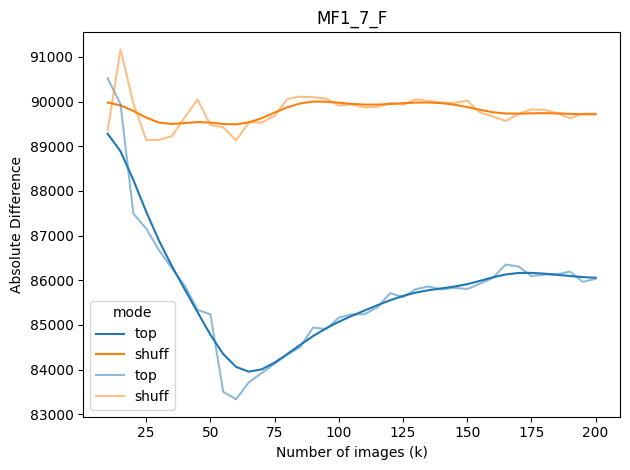

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.18s/it]


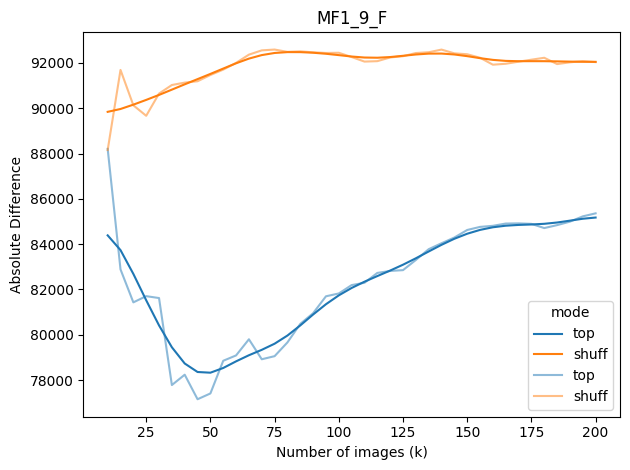

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [03:00<00:00,  4.52s/it]


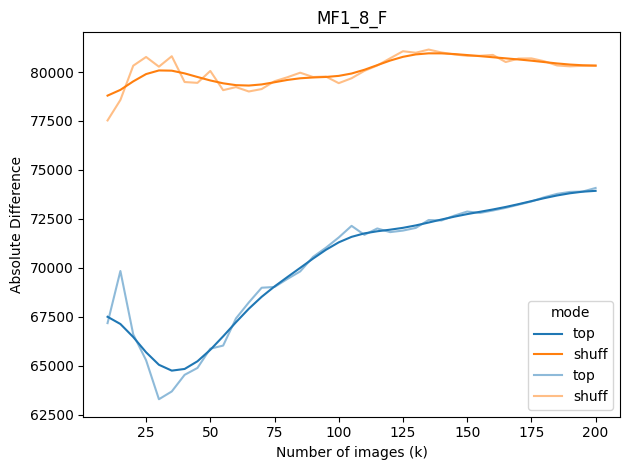

In [67]:
for _roi in ['Unknown_19_F', 'MF1_7_F', 'MF1_9_F', 'MF1_8_F']:
    step = 5

    sizes_top,   top_rdms   = geo_rdm(dat, roi=_roi, mode='top',   step=step)
    sizes_shuff, shuff_rdms = geo_rdm(dat, roi=_roi, mode='shuff', step=step)
    
    def rdm_diffs(rdm_seq, start=2):
        R0 = rdm_seq[start]
        triu = np.triu_indices_from(R0, k=1)
        diffs = [
            # 1 - spearmanr(rdm_seq[i][triu], rdm_seq[i-1][triu])[0]
            np.sum(np.abs(rdm_seq[i][triu]))
            for i in range(start, len(rdm_seq))
        ]
        ks = [sizes_top[i] for i in range(start, len(rdm_seq))]
        return ks, diffs
    
    k_top,   diffs_top   = rdm_diffs(top_rdms, start=1)
    k_shuff, diffs_shuff = rdm_diffs(shuff_rdms, start=1)
    
    df = pd.DataFrame({
        "k":     k_top + k_shuff,
        "diff":  diffs_top + diffs_shuff,
        "mode":  ["top"]*len(diffs_top) + ["shuff"]*len(diffs_shuff),
    })
    
    df["diff_smooth"] = df["diff"].groupby(df["mode"]).transform(
        lambda v: gaussian_filter1d(v, sigma=2)
    )
    
    sns.lineplot(data=df, x="k", y="diff_smooth", hue="mode")
    sns.lineplot(data=df, x="k", y="diff", hue="mode", alpha=0.5)
    
    plt.xlabel("Number of images (k)")
    plt.ylabel("Absolute Difference")
    plt.title(f'{_roi}')
    plt.tight_layout()
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:44<00:00,  1.11s/it]


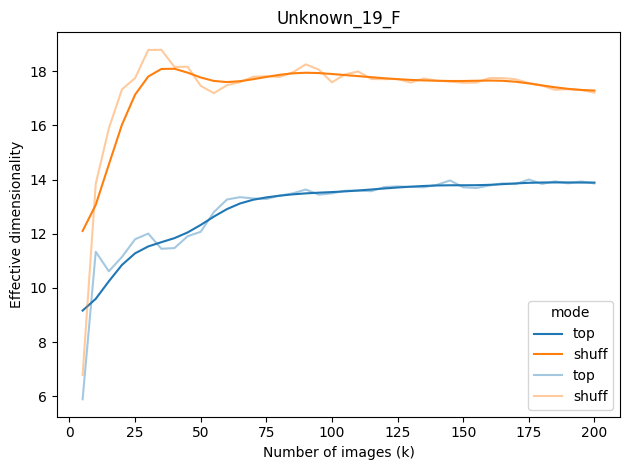

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:48<00:00,  1.21s/it]


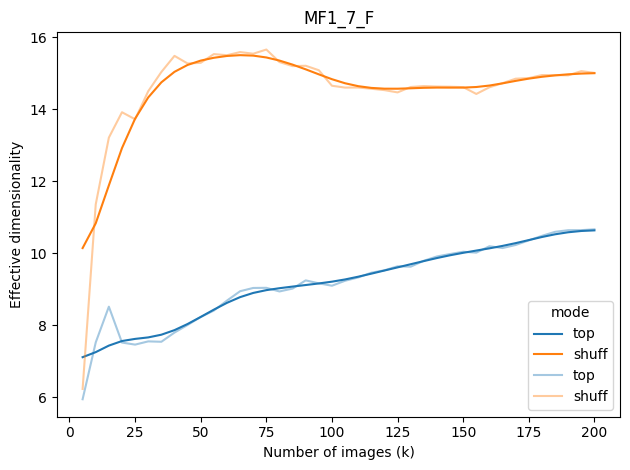

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:46<00:00,  1.16s/it]


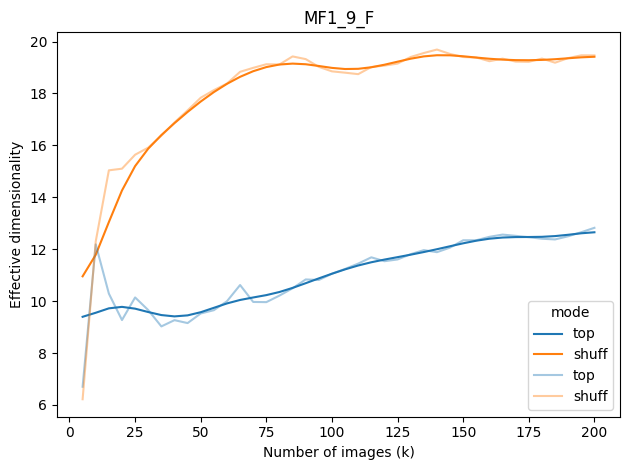

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:57<00:00,  4.45s/it]


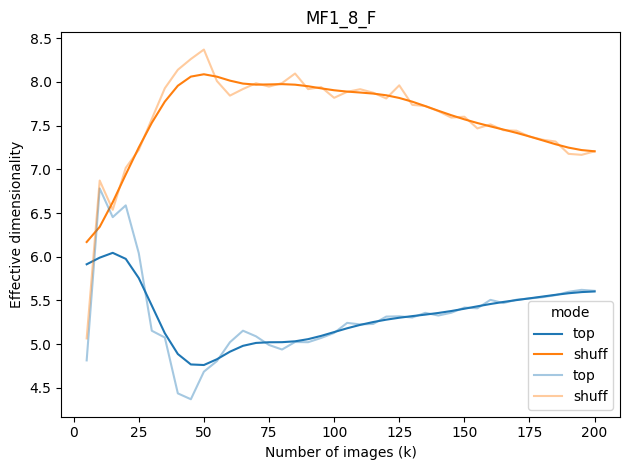

In [68]:
# EFFECTIVE DIMENSIONALITY
def effective_dimensionality(R):
    S = -0.5 * R**2
    lam = np.linalg.eigvalsh(S)
    lam = np.clip(lam, 0, None)
    return (lam.sum()**2) / (lam**2).sum()

cache = {}

for _roi in ['Unknown_19_F', 'MF1_7_F', 'MF1_9_F', 'MF1_8_F']:
    step = 5

    sizes_top,   top_rdms   = geo_rdm(dat, roi=_roi, mode='top',   step=step)
    sizes_shuff, shuff_rdms = geo_rdm(dat, roi=_roi, mode='shuff', step=step)

    def rdm_dim(rdm_seq, sizes):
        dims = [effective_dimensionality(R) for R in rdm_seq]
        return sizes, dims

    k_top,   dims_top   = rdm_dim(top_rdms,   sizes_top)
    k_shuff, dims_shuff = rdm_dim(shuff_rdms, sizes_shuff)

    df = pd.DataFrame({
        "k":   k_top + k_shuff,
        "dim": dims_top + dims_shuff,
        "mode": ["top"]*len(dims_top) + ["shuff"]*len(dims_shuff),
    })

    df["dim_smooth"] = df["dim"].groupby(df["mode"]).transform(
        lambda v: gaussian_filter1d(v, sigma=2)
    )

    cache[_roi] = {
        "sizes_top": sizes_top,
        "sizes_shuff": sizes_shuff,
        "top_rdms": top_rdms,
        "shuff_rdms": shuff_rdms,
    }

    sns.lineplot(data=df, x="k", y="dim_smooth", hue="mode")
    sns.lineplot(data=df, x="k", y="dim", hue="mode", alpha=0.4)

    plt.xlabel("Number of images (k)")
    plt.ylabel("Effective dimensionality")
    plt.title(f"{_roi}")
    plt.tight_layout()
    plt.show()